# Base Analysis of Game vs Stockfish.
- For one of the players.
- Look at the top moves in any given position.
- Look at the +/- of the move they made.

In [1]:
import pandas as pd
import numpy as np

import chess
import chess.pgn
from stockfish import Stockfish
stockfish = Stockfish(path="/usr/games/stockfish", depth=5, parameters={"Threads": 32, "Minimum Thinking Time": 5})

from tqdm.notebook import tqdm, trange

import seaborn as sns
import matplotlib.pyplot as plt

## Load FENS of a Player

In [229]:
def get_games_df(pgn_file):
    headers = []
    games = []
    mainline_moves = []
    ngames = 1659
    with open(pgn_file, mode='r', encoding="utf-8") as pgn:
        while True:
            header = chess.pgn.read_headers(pgn)
            if header is None:
                break
            headers.append(header)
            
    with open(pgn_file, mode='r', encoding="utf-8") as pgn:
        for _ in trange(len(headers)):
            game = chess.pgn.read_game(pgn)
            games.append(game)
            moves = str(game.mainline_moves())
            mainline_moves.append(moves)
    games_df = pd.DataFrame(headers)
    games_df['Date_clean'] = pd.to_datetime(games_df['Date'])
    games_df = games_df.sort_values('Date_clean').reset_index(drop=True).copy()
    games_df['Online'] = games_df['Site'].str.endswith('INT')
    games_df['mainline_moves'] = mainline_moves
    return games_df

In [230]:
games_df = get_games_df("pgns/niemann.pgn")

  0%|          | 0/1659 [00:00<?, ?it/s]

'1. e4 e5 2. Nc3 Bc5 3. Bc4 d6 4. f4 Bxg1 5. Rxg1 Qh4+ 6. Ke2 Bg4+ 7. Ke3 exf4+ 8. Kd4 Nc6+ 9. Kd3 Nb4+ 10. Kd4 c5#'

<Game at 0x7f92154e32e0 ('?' vs. '?', '????.??.??')>

In [223]:
game.mainline()

<Mainline at 0x7f921c2e43a0 (1. e4 e5 2. Nc3 Bc5 3. Bc4 d6 4. f4 Bxg1 5. Rxg1 Qh4+ 6. Ke2 Bg4+ 7. Ke3 exf4+ 8. Kd4 Nc6+ 9. Kd3 Nb4+ 10. Kd4 c5#)>

In [225]:
str(game.mainline_moves())

'1. e4 e5 2. Nc3 Bc5 3. Bc4 d6 4. f4 Bxg1 5. Rxg1 Qh4+ 6. Ke2 Bg4+ 7. Ke3 exf4+ 8. Kd4 Nc6+ 9. Kd3 Nb4+ 10. Kd4 c5#'

In [218]:
game.eval()

  0%|          | 0/1659 [00:00<?, ?it/s]

# Loop through moves in the game

In [135]:
def get_move_ranks(game, player, disable_tqdm=True):
    board = game.board()
    top_moves = []
    evaluations = []

    mainline = game.mainline_moves()
    n_moves = len([g for g in mainline])


    move_number = 0
    move_ranks = []
    moves = []

    if game.headers['White'] == player:
        is_white = True
    elif game.headers['Black'] == player:
        is_white = False
    else:
        print('Player not in either black or white position')
        print(game.headers['White'])
        print(game.headers['Black'])
        return pd.DataFrame()

    for move in tqdm(game.mainline_moves(), total=n_moves, disable=disable_tqdm):
        move_number += 1
        board.push(move)
        if (move_number <= 20):
            # stockfish.set_fen_position(board.fen())
            top_moves.append([])
            evaluations.append(np.nan)
        if (move_number == 1):
            stockfish.set_fen_position(board.fen())
            top_moves.append(stockfish.get_top_moves(10))
            evaluations.append(stockfish.get_evaluation())
        # only evaluate player move
        elif ((move_number % 2 == 1) and is_white) | ((move_number % 2 != 1) and not is_white):
            moves.append(str(move))
            current_move_rank = np.nan
            for rank, m in enumerate(top_moves[-1]):
                if m['Move'] == str(move):
                    current_move_rank = rank + 1
            move_ranks.append(current_move_rank)

        else:
            stockfish.set_fen_position(board.fen())
            top_moves.append(stockfish.get_top_moves(10))
            evaluations.append(stockfish.get_evaluation())
    move_ranks_df = pd.DataFrame(data=np.array([moves, move_ranks]).T, columns=['move','move_rank'])
    move_ranks_df = pd.concat([move_ranks_df, pd.DataFrame(top_moves[1:])], axis=1)
    return move_ranks_df

In [19]:
player = 'Kasparov,G'
games_move_ranks_df = []
for i, row in tqdm(games_df[-100:].iterrows(), total=len(games_df[-100:])):
    g = row['game']
    move_ranks_df = get_move_ranks(g, player)
    move_ranks_df['game'] = g
    games_move_ranks_df.append(move_ranks_df)

  0%|          | 0/100 [00:00<?, ?it/s]

In [28]:
results = {}

Text(0.5, 1.0, 'Kasparov,G Move rank vs move number')

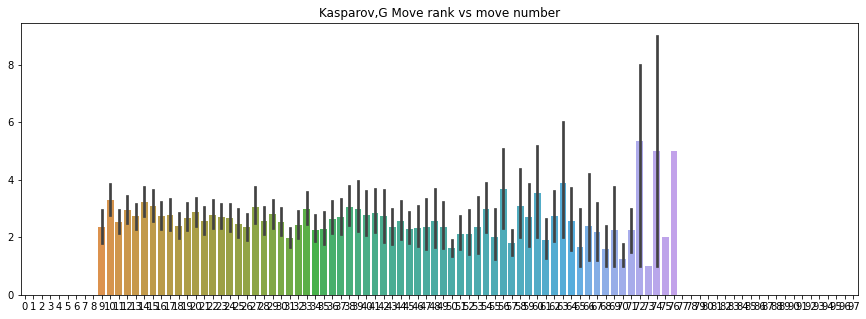

In [56]:
move_ranks = [g['move_rank'].astype('float') for g in games_move_ranks_df]
df = pd.DataFrame(move_ranks)

df_temp = df.T[10:].T.copy()
df_temp.index = games_df[-100:]['game']

results[player] = df_temp

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=df, ax=ax)
ax.set_title(player + ' Move rank vs move number')

<AxesSubplot:title={'center':'Distribution of Kasparov,G Last 100 Games Move Rank (Move 10+)'}, ylabel='Frequency'>

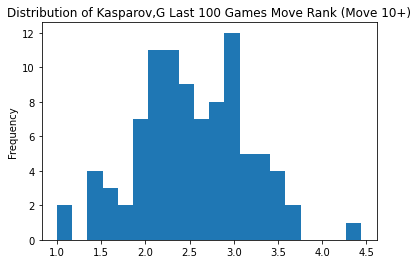

In [25]:
df.T[20:].T.mean(axis=1).plot(kind='hist', bins=20, title=f'Distribution of {player} Last 100 Games Move Rank (Move 10+)')

Text(0.5, 1.0, 'Kasparov,G: Moves vs Move Rank')

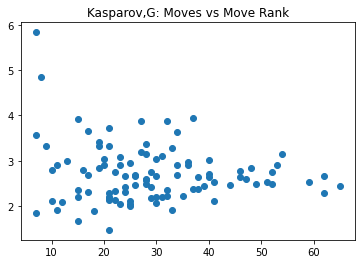

In [27]:
n_moves = (~df.isna()).sum(axis=1)
fig, ax= plt.subplots()
plt.scatter(x=n_moves,
            y=df.T[10:].T.mean(axis=1).values)
ax.set_title(f'{player}: Moves vs Move Rank')

# Magnus

In [57]:
games_df = get_games_df("pgns/Carlsen.pgn")

  0%|          | 0/4314 [00:00<?, ?it/s]

In [58]:
games_df['game'][0]

<Game at 0x7f4dcc541bb0 ('Carlsen,Magnus' vs. 'Brameld,A', '2001.01.06')>

In [62]:
player = 'Carlsen,M'
games_move_ranks_df = []
for i, row in tqdm(games_df[-100:].iterrows(), total=len(games_df[-100:])):
    g = row['game']
    move_ranks_df = get_move_ranks(g, player)
    move_ranks_df['game'] = g
    games_move_ranks_df.append(move_ranks_df)

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Carlsen,M Move rank vs move number')

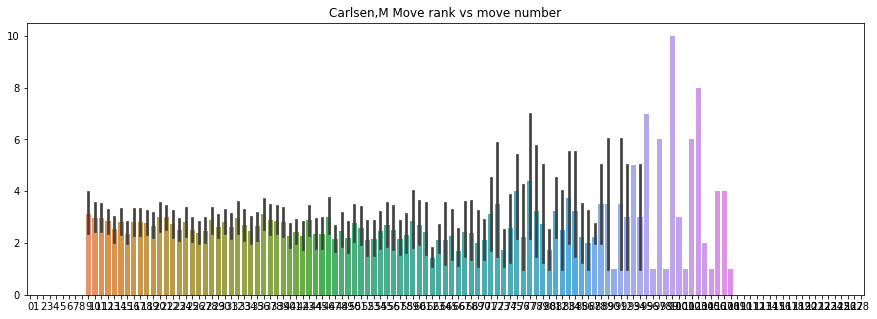

In [63]:
move_ranks = [g['move_rank'].astype('float') for g in games_move_ranks_df]
df = pd.DataFrame(move_ranks)

df_temp = df.T[10:].T.copy()
df_temp.index = games_df[-100:]['game']

results[player] = df_temp

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=df, ax=ax)
ax.set_title(player + ' Move rank vs move number')

<AxesSubplot:title={'center':'Distribution of Magnus Last 20 Games Move Rank (Move 10+)'}, ylabel='Frequency'>

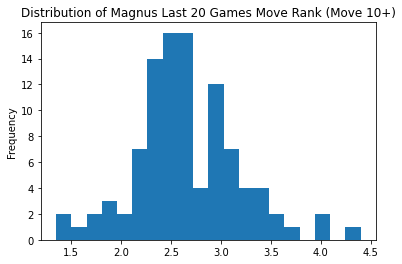

In [64]:
df.T[10:].T.mean(axis=1).plot(kind='hist', bins=20, title='Distribution of Magnus Last 20 Games Move Rank (Move 10+)')

In [65]:
n_moves = (~df.isna()).sum(axis=1)

Text(0.5, 1.0, 'Carlsen,M: Moves vs Move Rank')

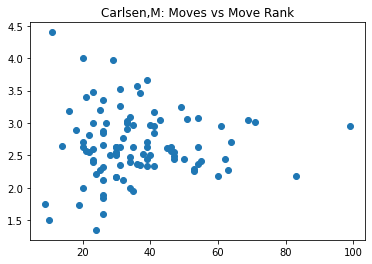

In [66]:
fig, ax= plt.subplots()
plt.scatter(x=n_moves,
            y=df.T[10:].T.mean(axis=1).values)
ax.set_title(f'{player}: Moves vs Move Rank')

# Same thing for Fabi

In [67]:
games_df = get_games_df("pgns/Caruana.pgn")

player = 'Caruana,F'
games_move_ranks_df = []
for i, row in tqdm(games_df[-100:].iterrows(), total=len(games_df[-100:])):
    g = row['game']
    move_ranks_df = get_move_ranks(g, player)
    move_ranks_df['game'] = g
    games_move_ranks_df.append(move_ranks_df)


  0%|          | 0/3429 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Player not in either black or white position
?
?


In [69]:
move_ranks = [g['move_rank'].astype('float') for g in games_move_ranks_df[:-1]]
df = pd.DataFrame(move_ranks)

df_temp = df.T[10:].T.copy()
df_temp.index = games_df[-100:-1]['game']

results[player] = df_temp

Text(0.5, 1.0, 'Caruana,F Move rank vs move number')

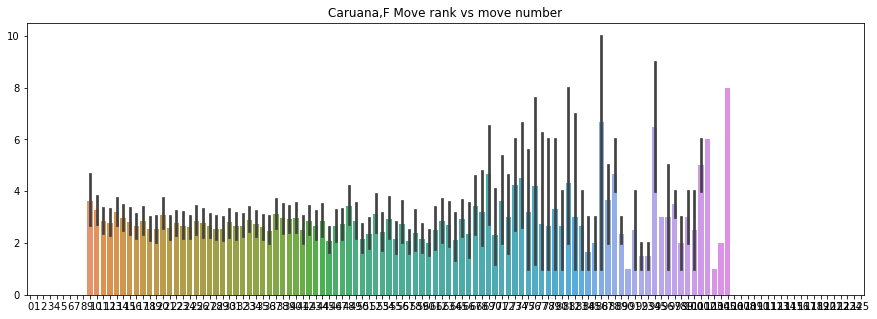

In [70]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=df, ax=ax)
ax.set_title(player + ' Move rank vs move number')

<AxesSubplot:title={'center':'Distribution of Fabi Last 20 Games Move Rank (Move 10+)'}, ylabel='Frequency'>

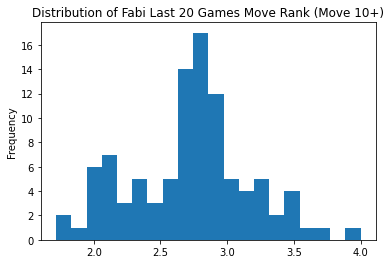

In [71]:
df.T[10:].T.mean(axis=1).plot(kind='hist', bins=20, title='Distribution of Fabi Last 20 Games Move Rank (Move 10+)')

Text(0.5, 1.0, 'Caruana,F: Moves vs Move Rank')

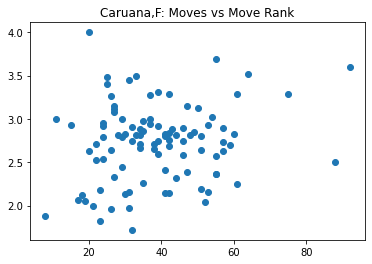

In [72]:
n_moves = (~df.isna()).sum(axis=1)
fig, ax= plt.subplots()
plt.scatter(x=n_moves,
            y=df.T[10:].T.mean(axis=1).values)
ax.set_title(f'{player}: Moves vs Move Rank')

In [74]:
results.keys()

dict_keys(['Kasparov,G', 'Carlsen,M', 'Caruana,F'])

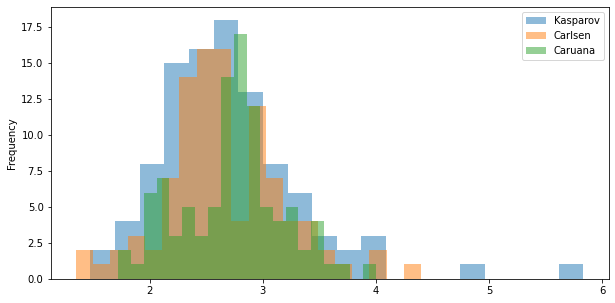

In [97]:
fig, ax = plt.subplots(figsize=(10, 5))
results['Kasparov,G'].mean(axis=1).plot(kind='hist', label='Kasparov', bins=20, alpha=0.5)
results['Carlsen,M'].mean(axis=1).plot(kind='hist', label='Carlsen', bins=20, alpha=0.5)
results['Caruana,F'].mean(axis=1).plot(kind='hist', label='Caruana', bins=20, alpha=0.5)
plt.legend()

In [119]:
pal = sns.color_palette()

Exception ignored in: <function Stockfish.__del__ at 0x7f4e6a5c61f0>
Traceback (most recent call last):
  File "/home/robmulla/anaconda3/envs/kaggle2/lib/python3.8/site-packages/stockfish/models.py", line 757, in __del__
    if self._stockfish.poll() is None:
AttributeError: 'Stockfish' object has no attribute '_stockfish'
Exception ignored in: <function Stockfish.__del__ at 0x7f4e6a5c61f0>
Traceback (most recent call last):
  File "/home/robmulla/anaconda3/envs/kaggle2/lib/python3.8/site-packages/stockfish/models.py", line 757, in __del__
    if self._stockfish.poll() is None:
AttributeError: 'Stockfish' object has no attribute '_stockfish'


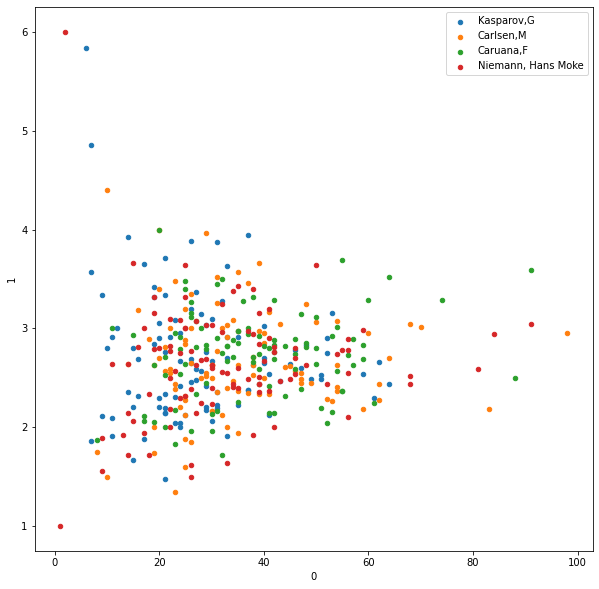

In [289]:
fig, ax = plt.subplots(figsize=(10, 10))
idx = 0
for i, d in results.items():
    pd.DataFrame([(~d.isna()).sum(axis=1), d.mean(axis=1)]).T.plot(x=0, y=1, kind='scatter', ax=ax, label=i, color=pal[idx])
    idx += 1

# Hans

In [136]:
games_df = get_games_df("pgns/niemann.pgn")
games_df = games_df.query('Online == False')

player = 'Niemann, Hans Moke'
games_move_ranks_df = []
for i, row in tqdm(games_df[-100:].iterrows(), total=len(games_df[-100:])):
    g = row['game']
    move_ranks_df = get_move_ranks(g, player)
    move_ranks_df['game'] = g
    games_move_ranks_df.append(move_ranks_df)


  0%|          | 0/1659 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [138]:
results = {}

In [139]:
move_ranks = [g['move_rank'].astype('float') for g in games_move_ranks_df]
df = pd.DataFrame(move_ranks)

df_temp = df.T[10:].T.copy()
df_temp.index = games_df[-100:]['game']

results[player] = df_temp

Text(0.5, 1.0, 'Niemann, Hans Moke Move rank vs move number')

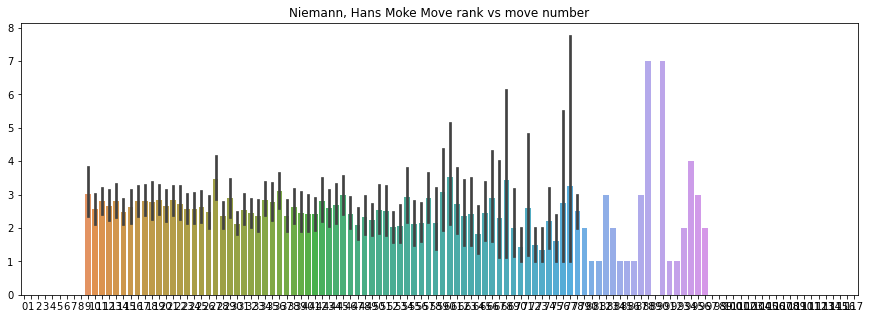

In [140]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=df, ax=ax)
ax.set_title(player + ' Move rank vs move number')

<AxesSubplot:title={'center':'Distribution of Hans Last 20 Games Move Rank (Move 10+)'}, ylabel='Frequency'>

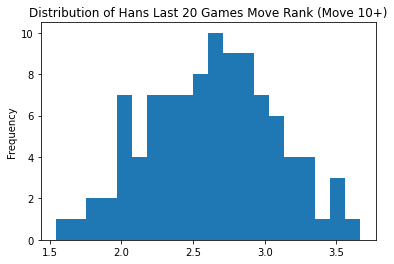

In [141]:
df.T[10:].T.mean(axis=1).plot(kind='hist', bins=20, title='Distribution of Hans Last 20 Games Move Rank (Move 10+)')

Text(0.5, 1.0, 'Niemann, Hans Moke: Moves vs Move Rank')

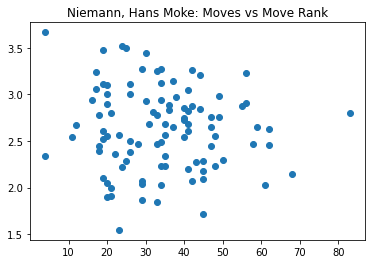

In [142]:
n_moves = (~df.isna()).sum(axis=1)
fig, ax= plt.subplots()
plt.scatter(x=n_moves,
            y=df.T[10:].T.mean(axis=1).values)
ax.set_title(f'{player}: Moves vs Move Rank')

In [146]:
results.keys()

dict_keys(['Niemann, Hans Moke'])

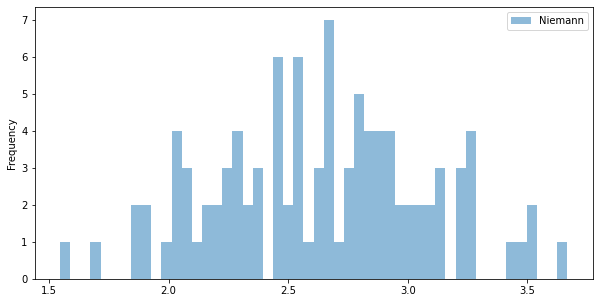

In [150]:
pal = sns.color_palette()
fig, ax = plt.subplots(figsize=(10, 5))
# results['Kasparov,G'].mean(axis=1).plot(kind='hist', label='Kasparov', bins=50, alpha=0.5)
# results['Carlsen,M'].mean(axis=1).plot(kind='hist', label='Carlsen', bins=50, alpha=0.5)
# results['Caruana,F'].mean(axis=1).plot(kind='hist', label='Caruana', bins=50, alpha=0.5)
results['Niemann, Hans Moke'].mean(axis=1).plot(kind='hist', label='Niemann', bins=50, alpha=0.5)

plt.legend()

In [180]:
results['Niemann, Hans Moke']['Date'] = games_df.tail(100)['Date'].values
results['Niemann, Hans Moke']['Black'] = games_df.tail(100)['Black'].values
results['Niemann, Hans Moke']['White'] = games_df.tail(100)['White'].values

In [195]:
pd.set_option('display.max_columns', 500)

In [196]:
games_df.loc[games_df['Black'].str.contains('Gretarsson')]

,Annotator,Black,BlackElo,BlackTeam,BlackTeamCountry,Date,ECO,Event,EventCategory,EventCountry,EventDate,EventRounds,EventType,PlyCount,Result,Round,Site,Source,SourceDate,SourceQuality,SourceTitle,SourceVersion,SourceVersionDate,Tiebreak,White,WhiteElo,WhiteTeam,WhiteTeamCountry,game,Date_clean,Online,mainline_moves,number_of_moves
1356,NaN,"Gretarsson, Hjorvar Steinn",2542,NaN,NaN,2022.04.09,B47,Reykjavik Kvika op,NaN,ISL,2022.04.06,9,swiss,73,1-0,5,Reykjavik,Chessbase,2022.04.21,1,Mega2022 Update 25,1,2022.04.21,NaN,"Niemann, Hans Moke",2637,NaN,NaN,"[Event ""Reykjavik Kvika op""]\n[Site ""Reykjavik...",2022-04-09,False,1. e4 c5 2. Nf3 e6 3. d4 cxd4 4. Nxd4 Nc6 5. N...,73


In [ ]:
chess.

In [204]:
moves = games_df['mainline_moves'].values[0]

In [208]:
my_game = chess.pgn.Game()

In [192]:
results['Niemann, Hans Moke']

,10,11,12,13,14,15,16,17,18,19,...,111,112,113,114,115,116,117,Date,Black,White
game,,,,,,,,,,,,,,,,,,,,,
"[Event ""Bundesliga 2122""]\n[Site ""Germany""]\n[Date ""2022.05.14""]\n[Round ""7.2""]\n[White ""Fridman, Daniel""]\n[Black ""Niemann, Hans Moke""]\n[Result ""1/2-1/2""]\n[BlackElo ""2642""]\n[BlackTeam ""Kiel Turm""]\n[BlackTeamCountry ""GER""]\n[ECO ""E15""]\n[EventCountry ""GER""]\n[EventDate ""2022.03.05""]\n[EventRounds ""15""]\n[EventType ""team-tourn""]\n[PlyCount ""104""]\n[Source ""Chessbase""]\n[SourceDate ""2022.05.20""]\n[SourceQuality ""1""]\n[SourceTitle ""Mega2022 Update 29""]\n[SourceVersion ""1""]\n[SourceVersionDate ""2022.05.20""]\n[WhiteElo ""2628""]\n[WhiteTeam ""Muelheim Nord""]\n[WhiteTeamCountry ""GER""]\n\n1. d4 Nf6 2. c4 e6 3. Nf3 b6 4. g3 Ba6 5. Qa4 Bb7 6. Bg2 c5 7. dxc5 bxc5 8. Nc3 Be7 9. O-O O-O 10. Rd1 d6 11. Bf4 Qb6 12. Qb5 Rd8 13. Rd2 Nbd7 14. Rad1 Ne8 15. b3 Qc7 16. Qa4 a6 17. Qa3 h6 18. Qc1 Ndf6 19. h3 g5 20. Be3 d5 21. cxd5 exd5 22. Nxg5 hxg5 23. Nxd5 Nxd5 24. Bxd5 Bxd5 25. Rxd5 Rxd5 26. Rxd5 Rd8 27. Rxd8 Qxd8 28. Bxc5 Qc8 29. Ba3 Qxc1+ 30. Bxc1 Nc7 31. Bd2 Kg7 32. Kf1 Nd5 33. e4 Nb4 34. Bc3+ Kg6 35. a3 Nc2 36. a4 f5 37. exf5+ Kxf5 38. Ke2 Ke4 39. f3+ Kd5 40. Kd3 Nb4+ 41. Ke3 Bc5+ 42. Ke2 Nc6 43. Kd3 Nb4+ 44. Ke2 Ke6 45. Bd2 Bd6 46. f4 gxf4 47. Bxf4 Bxf4 48. gxf4 Nd5 49. Kd3 Nxf4+ 50. Kc4 Kd6 51. Kb4 Nxh3 52. Ka5 Kc7 1/2-1/2",3.0,4.0,5.0,3.0,NaN,1.0,1.0,5.0,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022.05.14,"Niemann, Hans Moke","Fridman, Daniel"
"[Event ""Bundesliga 2122""]\n[Site ""Germany""]\n[Date ""2022.05.15""]\n[Round ""8.1""]\n[White ""Niemann, Hans Moke""]\n[Black ""Areshchenko, Alexander""]\n[Result ""1-0""]\n[BlackElo ""2670""]\n[BlackTeam ""Werder Bremen""]\n[BlackTeamCountry ""GER""]\n[ECO ""B51""]\n[EventCountry ""GER""]\n[EventDate ""2022.03.05""]\n[EventRounds ""15""]\n[EventType ""team-tourn""]\n[PlyCount ""85""]\n[Source ""Chessbase""]\n[SourceDate ""2022.05.20""]\n[SourceQuality ""1""]\n[SourceTitle ""Mega2022 Update 29""]\n[SourceVersion ""1""]\n[SourceVersionDate ""2022.05.20""]\n[WhiteElo ""2642""]\n[WhiteTeam ""Kiel Turm""]\n[WhiteTeamCountry ""GER""]\n\n1. e4 c5 2. Nf3 d6 3. Bb5+ Nd7 4. O-O a6 5. Bd3 Ngf6 6. Re1 e6 { Die\nHauptvariante 6...e6 punktet besser als 6...b5. } 7. Bf1 b5 8. a4 Bb7 9. d4 $146 ( { Vorgänger: } 9. d3 Be7 10. c3 O-O 11. Nbd2 Re8 12. Nb3 Bf8 13. Bf4 Qb6 14. Nbd2 Bc6 15. h3 { 0-1 (51) Tomashevsky,E (2702)-Kevlishvili,R (2451) Chess.com\nINT 2019 } ) 9... cxd4 10. axb5 axb5 11. Rxa8 Qxa8 12. Nxd4 b4 13. Nb5 Qb8 14. Bf4 e5 15. Bd2 Bc6 16. Qe2 Nxe4 17. Bxb4 Be7 18. N1c3 Nxc3 19. bxc3 O-O 20. Nd4 exd4 21. Qxe7 dxc3 22. Bxd6 Qa8 23. Bc4 h6 24. Qe3 Qa4 25. Qf4 Qxc2 26. Bxf8 Qg6 27. Qg3 Nxf8 28. Qxg6 Nxg6 29. Rc1 Nf4 30. f3 Nd5 31. Bxd5 Bxd5 32. Rxc3 g5 33. Kf2 Kg7 34. Ke3 Kf6 35. Kd4 Be6 36. Rc5 Bb3 37. Ke4 Be6 38. Rc6 Ke7 39. Ke5 f6+ 40. Kd4 h5 41. Rc7+ Kd8 42. Rh7 h4 43. f4 1-0",3.0,1.0,5.0,2.0,2.0,1.0,NaN,2.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022.05.15,"Areshchenko, Alexander","Niemann, Hans Moke"
"[Event ""Sharjah Masters 5th""]\n[Site ""Sharjah""]\n[Date ""2022.05.21""]\n[Round ""1""]\n[White ""Van Foreest, Lucas""]\n[Black ""Niemann, Hans Moke""]\n[Result ""1-0""]\n[BlackElo ""2656""]\n[ECO ""D35""]\n[EventCountry ""UAE""]\n[EventDate ""2022.05.21""]\n[EventRounds ""9""]\n[EventType ""swiss""]\n[PlyCount ""63""]\n[Source ""Chessbase""]\n[SourceDate ""2022.06.02""]\n[SourceQuality ""1""]\n[SourceTitle ""Mega2022 Update 31""]\n[SourceVersion ""1""]\n[SourceVersionDate ""2022.06.02""]\n[WhiteElo ""2572""]\n\n1. d4 Nf6 2. c4 e6 3. Nc3 d5 4. cxd5 exd5 5. Bg5 c6 6. e3 Be7 7. Bd3 h6 8. Bf4 Nbd7 9. h3 Nf8 10. Nf3 Ne6 11. Bh2 O-O 12. O-O b6 13. Rc1 Bb7 14. Qe2 c5 15. dxc5 bxc5 16. Rfd1 Qb6 17. b3 Rfe8 18. Be5 a6 19. Bf5 Bc6 20. Na4 Bxa4 21. bxa4 Red8 22. Rb1 Qc6 23. a5 Nd7 24. Bg3 Rac8 25. Ne5 Nxe5 26. Bxe5 d4 27. exd4 cxd4 28. Rb6 Qe8 29. Rxe6 fxe6 30. Bxe6+ Kh8 31. Bxc8 Bf6 32. Bxa6 1-0",1.0,1.0,2.0,2.0,1.0,1.0,5.0,NaN,4.0,4.0,...,NaN,NaN,NaN,

In [186]:
results['Niemann, Hans Moke'].loc[results['Niemann, Hans Moke']['White'].str.contains('Gretarsson')]

,10,11,12,13,14,15,16,17,18,19,...,111,112,113,114,115,116,117,Date,Black,White
game,,,,,,,,,,,,,,,,,,,,,


In [172]:
results['Niemann, Hans Moke']

,10,11,12,13,14,15,16,17,18,19,...,109,110,111,112,113,114,115,116,117,Date
game,,,,,,,,,,,,,,,,,,,,,
"[Event ""Bundesliga 2122""]\n[Site ""Germany""]\n[Date ""2022.05.14""]\n[Round ""7.2""]\n[White ""Fridman, Daniel""]\n[Black ""Niemann, Hans Moke""]\n[Result ""1/2-1/2""]\n[BlackElo ""2642""]\n[BlackTeam ""Kiel Turm""]\n[BlackTeamCountry ""GER""]\n[ECO ""E15""]\n[EventCountry ""GER""]\n[EventDate ""2022.03.05""]\n[EventRounds ""15""]\n[EventType ""team-tourn""]\n[PlyCount ""104""]\n[Source ""Chessbase""]\n[SourceDate ""2022.05.20""]\n[SourceQuality ""1""]\n[SourceTitle ""Mega2022 Update 29""]\n[SourceVersion ""1""]\n[SourceVersionDate ""2022.05.20""]\n[WhiteElo ""2628""]\n[WhiteTeam ""Muelheim Nord""]\n[WhiteTeamCountry ""GER""]\n\n1. d4 Nf6 2. c4 e6 3. Nf3 b6 4. g3 Ba6 5. Qa4 Bb7 6. Bg2 c5 7. dxc5 bxc5 8. Nc3 Be7 9. O-O O-O 10. Rd1 d6 11. Bf4 Qb6 12. Qb5 Rd8 13. Rd2 Nbd7 14. Rad1 Ne8 15. b3 Qc7 16. Qa4 a6 17. Qa3 h6 18. Qc1 Ndf6 19. h3 g5 20. Be3 d5 21. cxd5 exd5 22. Nxg5 hxg5 23. Nxd5 Nxd5 24. Bxd5 Bxd5 25. Rxd5 Rxd5 26. Rxd5 Rd8 27. Rxd8 Qxd8 28. Bxc5 Qc8 29. Ba3 Qxc1+ 30. Bxc1 Nc7 31. Bd2 Kg7 32. Kf1 Nd5 33. e4 Nb4 34. Bc3+ Kg6 35. a3 Nc2 36. a4 f5 37. exf5+ Kxf5 38. Ke2 Ke4 39. f3+ Kd5 40. Kd3 Nb4+ 41. Ke3 Bc5+ 42. Ke2 Nc6 43. Kd3 Nb4+ 44. Ke2 Ke6 45. Bd2 Bd6 46. f4 gxf4 47. Bxf4 Bxf4 48. gxf4 Nd5 49. Kd3 Nxf4+ 50. Kc4 Kd6 51. Kb4 Nxh3 52. Ka5 Kc7 1/2-1/2",3.0,4.0,5.0,3.0,NaN,1.0,1.0,5.0,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"[Event ""Bundesliga 2122""]\n[Site ""Germany""]\n[Date ""2022.05.15""]\n[Round ""8.1""]\n[White ""Niemann, Hans Moke""]\n[Black ""Areshchenko, Alexander""]\n[Result ""1-0""]\n[BlackElo ""2670""]\n[BlackTeam ""Werder Bremen""]\n[BlackTeamCountry ""GER""]\n[ECO ""B51""]\n[EventCountry ""GER""]\n[EventDate ""2022.03.05""]\n[EventRounds ""15""]\n[EventType ""team-tourn""]\n[PlyCount ""85""]\n[Source ""Chessbase""]\n[SourceDate ""2022.05.20""]\n[SourceQuality ""1""]\n[SourceTitle ""Mega2022 Update 29""]\n[SourceVersion ""1""]\n[SourceVersionDate ""2022.05.20""]\n[WhiteElo ""2642""]\n[WhiteTeam ""Kiel Turm""]\n[WhiteTeamCountry ""GER""]\n\n1. e4 c5 2. Nf3 d6 3. Bb5+ Nd7 4. O-O a6 5. Bd3 Ngf6 6. Re1 e6 { Die\nHauptvariante 6...e6 punktet besser als 6...b5. } 7. Bf1 b5 8. a4 Bb7 9. d4 $146 ( { Vorgänger: } 9. d3 Be7 10. c3 O-O 11. Nbd2 Re8 12. Nb3 Bf8 13. Bf4 Qb6 14. Nbd2 Bc6 15. h3 { 0-1 (51) Tomashevsky,E (2702)-Kevlishvili,R (2451) Chess.com\nINT 2019 } ) 9... cxd4 10. axb5 axb5 11. Rxa8 Qxa8 12. Nxd4 b4 13. Nb5 Qb8 14. Bf4 e5 15. Bd2 Bc6 16. Qe2 Nxe4 17. Bxb4 Be7 18. N1c3 Nxc3 19. bxc3 O-O 20. Nd4 exd4 21. Qxe7 dxc3 22. Bxd6 Qa8 23. Bc4 h6 24. Qe3 Qa4 25. Qf4 Qxc2 26. Bxf8 Qg6 27. Qg3 Nxf8 28. Qxg6 Nxg6 29. Rc1 Nf4 30. f3 Nd5 31. Bxd5 Bxd5 32. Rxc3 g5 33. Kf2 Kg7 34. Ke3 Kf6 35. Kd4 Be6 36. Rc5 Bb3 37. Ke4 Be6 38. Rc6 Ke7 39. Ke5 f6+ 40. Kd4 h5 41. Rc7+ Kd8 42. Rh7 h4 43. f4 1-0",3.0,1.0,5.0,2.0,2.0,1.0,NaN,2.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"[Event ""Sharjah Masters 5th""]\n[Site ""Sharjah""]\n[Date ""2022.05.21""]\n[Round ""1""]\n[White ""Van Foreest, Lucas""]\n[Black ""Niemann, Hans Moke""]\n[Result ""1-0""]\n[BlackElo ""2656""]\n[ECO ""D35""]\n[EventCountry ""UAE""]\n[EventDate ""2022.05.21""]\n[EventRounds ""9""]\n[EventType ""swiss""]\n[PlyCount ""63""]\n[Source ""Chessbase""]\n[SourceDate ""2022.06.02""]\n[SourceQuality ""1""]\n[SourceTitle ""Mega2022 Update 31""]\n[SourceVersion ""1""]\n[SourceVersionDate ""2022.06.02""]\n[WhiteElo ""2572""]\n\n1. d4 Nf6 2. c4 e6 3. Nc3 d5 4. cxd5 exd5 5. Bg5 c6 6. e3 Be7 7. Bd3 h6 8. Bf4 Nbd7 9. h3 Nf8 10. Nf3 Ne6 11. Bh2 O-O 12. O-O b6 13. Rc1 Bb7 14. Qe2 c5 15. dxc5 bxc5 16. Rfd1 Qb6 17. b3 Rfe8 18. Be5 a6 19. Bf5 Bc6 20. Na4 Bxa4 21. bxa4 Red8 22. Rb1 Qc6 23. a5 Nd7 24. Bg3 Rac8 25. Ne5 Nxe5 26. Bxe5 d4 27. exd4 cxd4 28. Rb6 Qe8 29. Rxe6 fxe6 30. Bxe6+ Kh8 31. Bxc8 Bf6 32. Bxa6 1-0",1.0,1.0,2.0,2.0,1.0,1.0,5.0,NaN,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"[Event ""Sharjah Masters 5th""]\n[Site ""Sharjah""]\n[Date

In [161]:
Gretarsson

NameError: name 'Gretarsson' is not defined

In [159]:
games_df.loc[games_df['Event'].str.contains('Rey')]

,Annotator,Black,BlackElo,BlackTeam,BlackTeamCountry,Date,ECO,Event,EventCategory,EventCountry,...,Tiebreak,White,WhiteElo,WhiteTeam,WhiteTeamCountry,game,Date_clean,Online,mainline_moves,number_of_moves
96,NaN,"Palmeri, Ralph P",1642,NaN,NaN,2015.03.10,A43,Reykjavik op,NaN,ISL,...,NaN,"Niemann, Hans Moke",2275,NaN,NaN,"[Event ""Reykjavik op""]\n[Site ""Reykjavik""]\n[D...",2015-03-10,False,1. d4 c5 2. d5 d6 3. c4 g6 4. Nf3 Nf6 5. Nc3 N...,79
97,NaN,"Stefansson, Vignir Vatnar",1909,NaN,NaN,2015.03.11,E16,Reykjavik op,NaN,ISL,...,NaN,"Niemann, Hans Moke",2275,NaN,NaN,"[Event ""Reykjavik op""]\n[Site ""Reykjavik""]\n[D...",2015-03-11,False,1. d4 Nf6 2. c4 e6 3. Nf3 b6 4. g3 Bb7 5. Bg2 ...,121
98,NaN,"Niemann, Hans Moke",2275,NaN,NaN,2015.03.11,E94,Reykjavik op,NaN,ISL,...,NaN,"Rasmussen, Allan Stig",2532,NaN,NaN,"[Event ""Reykjavik op""]\n[Site ""Reykjavik""]\n[D...",2015-03-11,False,1. d4 Nf6 2. c4 g6 3. Nc3 Bg7 4. e4 d6 5. Nf3 ...,88
99,NaN,"Niemann, Hans Moke",2275,NaN,NaN,2015.03.12,B22,Reykjavik op,NaN,ISL,...,NaN,"Borg, Flemming",1828,NaN,NaN,"[Event ""Reykjavik op""]\n[Site ""Reykjavik""]\n[D...",2015-03-12,False,1. e4 c5 2. c3 Nf6 3. d3 d6 4. g3 Nc6 5. f4 c4...,42
100,NaN,"Wang, Yiye",2433,NaN,NaN,2015.03.13,D23,Reykjavik op,NaN,ISL,...,NaN,"Niemann, Hans Moke",2275,NaN,NaN,"[Event ""Reykjavik op""]\n[Site ""Reykjavik""]\n[D...",2015-03-13,False,1. d4 d5 2. c4 c6 3. Nf3 Nf6 4. Qc2 dxc4 5. Qx...,126
101,NaN,"Niemann, Hans Moke",2275,NaN,NaN,2015.03.14,B70,Reykjavik op,NaN,ISL,...,NaN,"Baldvinsson, Loftur",1945,NaN,NaN,"[Event ""Reykjavik op""]\n[Site ""Reykjavik""]\n[D...",2015-03-14,False,1. e4 c5 2. Nf3 d6 3. d4 cxd4 4. Nxd4 Nf6 5. N...,167
102,NaN,"Hansen, Lars Henrik Bech",1994,NaN,NaN,2015.03.15,E92,Reykjavik op,NaN,ISL,...,NaN,"Niemann, Hans Moke",2275,NaN,NaN,"[Event ""Reykjavik op""]\n[Site ""Reykjavik""]\n[D...",2015-03-15,False,1. d4 g6 2. c4 Nf6 3. Nc3 Bg7 4. e4 d6 5. Nf3 ...,108
103,NaN,"Niemann, Hans Moke",2275,NaN,NaN,2015.03.16,A48,Reykjavik op,NaN,ISL,...,NaN,"Valtysson, Thor",1974,NaN,NaN,"[Event ""Reykjavik op""]\n[Site ""Reykjavik""]\n[D...",2015-03-16,False,1. d4 Nf6 2. Nf3 g6 3. Bf4 Bg7 4. e3 O-O 5. Be...,108
104,NaN,"Birkisson, Bardur Orn",1839,NaN,NaN,2015.03.17,E16,Reykjavik op,NaN,ISL,...,NaN,"Niemann, Hans Moke",2275,NaN,NaN,"[Event ""Reykjavik op""]\n[Site ""Reykjavik""]\n[D...",2015-03-17,False,1. d4 Nf6 2. c4 e6 3. Nf3 Bb4+ 4. Bd2 a5 5. g3...,107
105,NaN,"Niemann, Hans Moke",2275,NaN,NaN,2015.03.18,B01,Reykjavik op,NaN,ISL,...,NaN,"Sequera Paolini, Jose Rafael",2408,NaN,NaN,"[Event ""Reykjavik op""]\n[Site ""Reykjavik""]\n[D...",2015-03-18,False,1. e4 d5 2. exd5 Qxd5 3. Nc3 Qd6 4. d4 c6 5. g...,126


In [156]:
games_df['Event'].value_counts().head(20)

Miami FTX Crypto Cup                 25
Wch Blitz                            21
USA-ch U20                           18
Prague Challengers 4th               18
Lindores Abbey Blitz Tal Memorial    18
Sharjah Masters 5th                  18
Charlotte CCCSA IM                   18
Jermuk Avagyan Memorial              18
Wch U12                              17
USA-ch U16                           16
Las Vegas National op                15
US Masters op                        14
San Francisco TNM Summer op          14
San Francisco TNM Fall op            13
San Francisco TNM Spring op          13
Wch Rapid                            13
San Francisco TNM Winter op          13
SRB-chT Premier                      11
FIDE Grand Swiss                     11
Wch U16                              11
Name: Event, dtype: int64

In [151]:
# fig, ax = plt.subplots(figsize=(15, 10))
# idx = 0
# for i, d in results.items():
#     pd.DataFrame([(~d.isna()).sum(axis=1), d.mean(axis=1)]).T.plot(x=0, y=1, kind='scatter', ax=ax, label=i, color=pal[idx])
#     idx += 1